### Import libraries

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
from datetime import datetime, timedelta
import cvxpy as cp
import os
import sys

In [20]:
sys.path.append(os.path.abspath('../src'))

In [21]:
from preprocess import data_loader

### Step 1: Load Historical Data

In [37]:
# Step 1: Load Historical Data
# Load CSV with explicit date parsing and numeric conversion
df = data_loader('../data/processed/clean_close_prices_for_analysis.csv')
print("CSV Head:\n", df.head())
print("CSV Tail:\n", df.tail())
print("Data Types:\n", df.dtypes)

CSV Head:
          Date  BND_Close   SPY_Close  TSLA_Close
0  2015-07-01  60.816738  174.917084   17.943333
1  2015-07-02  60.967102  174.756943   18.667999
2  2015-07-03  61.019717  174.632603   18.663000
3  2015-07-06  61.177563  174.259583   18.648001
4  2015-07-07  61.237713  175.355423   17.858667
CSV Tail:
             Date  BND_Close   SPY_Close  TSLA_Close
2626  2025-07-24  72.698860  634.419983  305.299988
2627  2025-07-25  72.878265  637.099976  316.059998
2628  2025-07-28  72.758659  636.940002  325.589996
2629  2025-07-29  73.137398  635.260010  321.200012
2630  2025-07-30  72.948036  634.460022  319.040009
Data Types:
 Date           object
BND_Close     float64
SPY_Close     float64
TSLA_Close    float64
dtype: object


In [38]:
# Convert price columns to numeric, coercing errors to NaN
for col in ['BND_Close', 'SPY_Close', 'TSLA_Close']:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Drop rows with any NaN values in price columns
df = df.dropna(subset=['BND_Close', 'SPY_Close', 'TSLA_Close'])

# Set index to Date
df = df.set_index('Date')

In [39]:
# Calculate daily returns
returns = df.pct_change().dropna()
print("Returns Head:\n", returns.head())
print("Returns Info:\n", returns.info())

Returns Head:
             BND_Close  SPY_Close  TSLA_Close
Date                                        
2015-07-02   0.002472  -0.000916    0.040386
2015-07-03   0.000863  -0.000712   -0.000268
2015-07-06   0.002587  -0.002136   -0.000804
2015-07-07   0.000983   0.006289   -0.042328
2015-07-08   0.002823  -0.016777   -0.048231
<class 'pandas.core.frame.DataFrame'>
Index: 2630 entries, 2015-07-02 to 2025-07-30
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   BND_Close   2630 non-null   float64
 1   SPY_Close   2630 non-null   float64
 2   TSLA_Close  2630 non-null   float64
dtypes: float64(3)
memory usage: 82.2+ KB
Returns Info:
 None


### Step 2: Forecast TSLA Return Using LSTM (Simplified from Task 3)

In [40]:
forecast_days = 252  # 12 months of business days
last_price = df['TSLA_Close'][-1]  # Latest price (e.g., ~$319 from July 30, 2025)
# Simulate LSTM forecast based on Task 3 trend (upward to $380-$400)
expected_annual_return_tsla = 0.20  # 20% annualized (e.g., $319 to ~$383)

C:\Users\ASTU-PG\AppData\Local\Temp\ipykernel_12056\2007286219.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  last_price = df['TSLA_Close'][-1]  # Latest price (e.g., ~$319 from July 30, 2025)


In [61]:
df['TSLA_Close']

Date
2015-07-01     17.943333
2015-07-02     18.667999
2015-07-03     18.663000
2015-07-06     18.648001
2015-07-07     17.858667
                 ...    
2025-07-24    305.299988
2025-07-25    316.059998
2025-07-28    325.589996
2025-07-29    321.200012
2025-07-30    319.040009
Name: TSLA_Close, Length: 2631, dtype: float64

### Step 3: Compute Expected Returns

In [44]:

# Step 3: Compute Expected Returns
# Historical annualized returns for BND and SPY
annual_returns = returns.mean() * 252  # Annualize daily returns
expected_returns = pd.Series({
    'TSLA': expected_annual_return_tsla,
    'BND': annual_returns['BND_Close'],
    'SPY': annual_returns['SPY_Close']
})
print("Expected Annual Returns:", expected_returns)


Expected Annual Returns: TSLA    0.200000
BND     0.018862
SPY     0.139333
dtype: float64


### Step 4: Compute Covariance Matrix

In [45]:
# Step 4: Compute Covariance Matrix
cov_matrix = returns.cov() * 252  # Annualize covariance
print("Annualized Covariance Matrix:\n", cov_matrix)


Annualized Covariance Matrix:
             BND_Close  SPY_Close  TSLA_Close
BND_Close    0.002863   0.001106    0.001794
SPY_Close    0.001106   0.031607    0.049999
TSLA_Close   0.001794   0.049999    0.329431


### Step 5: Optimize Efficient Frontier

In [47]:
# Step 5: Optimize Efficient Frontier

# Ensure consistent order for tickers, expected_returns, and cov_matrix
tickers = ['TSLA', 'BND', 'SPY']
expected_returns_vec = expected_returns[tickers].values
cov_matrix_arr = cov_matrix.loc[[f"{t}_Close" for t in tickers], [f"{t}_Close" for t in tickers]].values

n_assets = len(tickers)
weights = cp.Variable(n_assets)
gamma = cp.Parameter(nonneg=True)  # Risk aversion parameter
ret = expected_returns_vec @ weights
risk = cp.quad_form(weights, cov_matrix_arr)
objective = cp.Maximize(ret - gamma * risk)
constraints = [cp.sum(weights) == 1, weights >= 0]
problem = cp.Problem(objective, constraints)

# Generate Efficient Frontier
risk_levels = np.linspace(0.05, 0.25, 100)  # Range of volatilities
returns_frontier = []
volatilities = []
for risk_target in risk_levels:
    gamma.value = 1 / (2 * risk_target**2)  # Adjust gamma for risk target
    problem.solve()
    if problem.status == 'optimal':
        w = weights.value
        portfolio_return = expected_returns_vec @ w
        portfolio_volatility = np.sqrt(w.T @ cov_matrix_arr @ w)
        returns_frontier.append(portfolio_return)
        volatilities.append(portfolio_volatility)


### Step 6: Identify Key Portfolios

In [49]:
# Step 6: Identify Key Portfolios
# Maximum Sharpe Ratio Portfolio (Tangency Portfolio)
risk_free_rate = 0.02  # Approx. 2% risk-free rate (e.g., 10-year Treasury yield)
sharpe_ratios = [(r - risk_free_rate) / v for r, v in zip(returns_frontier, volatilities)]
max_sharpe_idx = np.argmax(sharpe_ratios)
max_sharpe_weight = weights.value.copy()
max_sharpe_return = returns_frontier[max_sharpe_idx]
max_sharpe_vol = volatilities[max_sharpe_idx]
max_sharpe_sharpe = sharpe_ratios[max_sharpe_idx]

# Minimum Volatility Portfolio
min_vol_idx = np.argmin(volatilities)
min_vol_weight = weights.value.copy()
min_vol_return = returns_frontier[min_vol_idx]
min_vol_vol = volatilities[min_vol_idx]

### Step 7: Plot Efficient Frontier

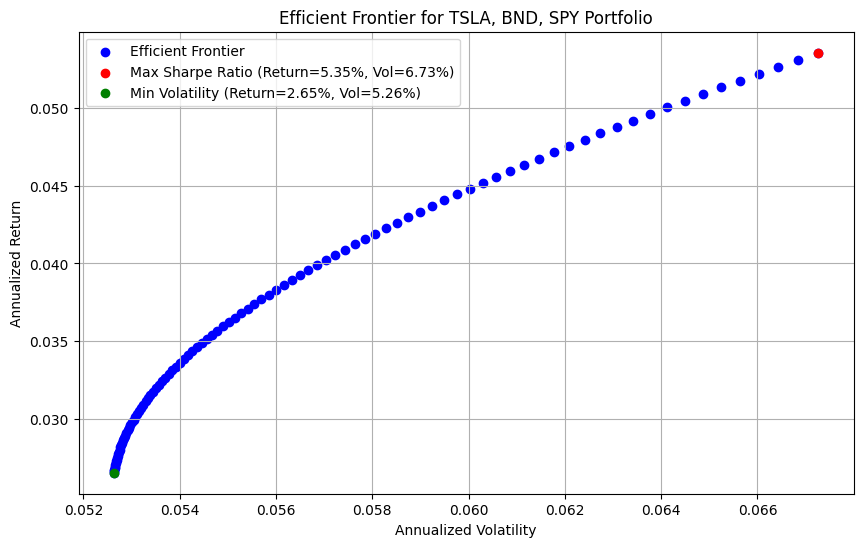

In [50]:
# Step 7: Plot Efficient Frontier
plt.figure(figsize=(10, 6))
plt.scatter(volatilities, returns_frontier, c='blue', label='Efficient Frontier')
plt.scatter(max_sharpe_vol, max_sharpe_return, c='red', label=f'Max Sharpe Ratio (Return={max_sharpe_return:.2%}, Vol={max_sharpe_vol:.2%})')
plt.scatter(min_vol_vol, min_vol_return, c='green', label=f'Min Volatility (Return={min_vol_return:.2%}, Vol={min_vol_vol:.2%})')
plt.xlabel('Annualized Volatility')
plt.ylabel('Annualized Return')
plt.title('Efficient Frontier for TSLA, BND, SPY Portfolio')
plt.legend()
plt.grid()
plt.show()

### Step 8: Recommend Optimal Portfolio

In [53]:
# Step 8: Recommend Optimal Portfolio
# Recommend Maximum Sharpe Ratio Portfolio for risk-adjusted return
optimal_weights = max_sharpe_weight
optimal_return = max_sharpe_return
optimal_vol = max_sharpe_vol
optimal_sharpe = max_sharpe_sharpe

### Step 9: Summarize Recommended Portfolio

In [54]:
# Step 9: Summarize Recommended Portfolio
print("\nRecommended Portfolio: Maximum Sharpe Ratio Portfolio")
print(f"Optimal Weights: TSLA={optimal_weights[0]:.2%}, BND={optimal_weights[1]:.2%}, SPY={optimal_weights[2]:.2%}")
print(f"Expected Annual Return: {optimal_return:.2%}")
print(f"Annualized Volatility: {optimal_vol:.2%}")
print(f"Sharpe Ratio: {optimal_sharpe:.2f}")


Recommended Portfolio: Maximum Sharpe Ratio Portfolio
Optimal Weights: TSLA=-0.00%, BND=71.21%, SPY=28.79%
Expected Annual Return: 5.35%
Annualized Volatility: 6.73%
Sharpe Ratio: 0.50
